In [1]:
import numpy as np

# Parameters
num_individuals = 100000  # Increased from 500 for better averaging
num_periods = 40
rho = 0.75
alpha = 1.5
b = 1.8
R = 1.05
beta = 0.95
delta = 0.1
phi1 = 0.2
phi2 = 0.6
UB = 0
W = 1  # Simplified to be 1 * human capital
num_periods = 40
M_grid = np.linspace(0, 10, 100)
K_grid = np.linspace(0, 10, 100)
H_choices = [0, 0.5, 1]
sigma_xi = 0.1  # Standard deviation for the log-normal human capital shock
sigma_epsilon = 0.25  # Assumed value for the scale parameter of the taste shocks
    
# Generate human capital shock, log-normal
xi = np.random.lognormal(-0.5 * sigma_xi**2, sigma_xi)
    


In [9]:
import numpy as np

def utility(c, h, rho, alpha, b):
    if h != 0:
        return R * (M - c) + W * h
    else:
        return R * (M - c) + UB

def human_capital(K, h, delta, phi1, phi2, xi):    
    return ((1 - delta) * K + phi1 * h**phi2) * xi

def bellman_equation(V_next, c, h, M, K, beta, rho, alpha, b, R, W, UB, delta, phi1, phi2, sigma_epsilon, sigma_xi):
    # Generate taste shock
    epsilon = np.random.normal(0, sigma_epsilon)
    
    # Generate human capital shock, log-normal
    xi = np.random.lognormal(-0.5 * sigma_xi**2, sigma_xi)

    util = utility(c, h, rho, alpha, b) + epsilon
    M_next = next_wealth(M, c, h, R, W, UB)
    K_next = human_capital(K, h, delta, phi1, phi2, xi)
    expected_V_next = V_next(M_next, K_next)  # This needs to be calculated or approximated elsewhere
    return util + beta * expected_V_next


In [3]:
# Initialize value functions and consumption policy
V = np.zeros((num_periods+1, len(M_grid), len(K_grid), len(H_choices)))
C = np.zeros_like(V)

# Terminal condition: consume all wealth
V[-1] = M_grid[None, :, None, None]

# Backward induction with Upper Envelope
for t in range(num_periods - 1, -1, -1):
    for i, M in enumerate(M_grid):
        for j, K in enumerate(K_grid):
            for k, h in enumerate(H_choices):
                c_range = np.linspace(0, M, 50)  # Possible consumption values
                potential_outcomes = []
                for c in c_range:
                    M_next = R * (M - c) + h * K  # Correct use of K as wage multiplier
                    K_next = (1 - delta) * K + phi1 * h**phi2
                    xi = np.random.lognormal(-0.5 * sigma_xi**2, sigma_xi)
                    epsilon = np.random.normal(0, sigma_epsilon)
                    M_index = np.searchsorted(M_grid, M_next)
                    K_index = np.searchsorted(K_grid, K_next)
                    future_value = beta * V[t+1, M_index, K_index, k] if M_index < len(M_grid) and K_index < len(K_grid) else 0
                    utility = c**(1 - rho) / (1 - rho) - b * h**alpha / alpha + epsilon
                    potential_outcomes.append((utility + future_value, c))
                best_outcome = max(potential_outcomes, key=lambda x: x[0])
                V[t, i, j, k] = best_outcome[0]
                C[t, i, j, k] = best_outcome[1]

# Optional: Print or return the policy functions for consumption and corresponding value functions
print("Value function:", V)
print("Consumption policy:", C)

Value function: [[[[ 9.82651871 54.88409621 55.88612841]
   [ 9.68888373 57.8950571  58.67996301]
   [ 9.82003316 58.17552397 59.82312582]
   ...
   [ 9.80908138 84.46789363 88.22784985]
   [ 9.55743551 84.68048334 88.5899632 ]
   [ 9.85912271 84.54351075 89.12740511]]

  [[45.02168524 59.31435097 60.15036536]
   [45.81349301 60.40294733 61.12646436]
   [46.46458249 61.11646329 62.4325857 ]
   ...
   [45.20733257 86.70972224 90.31587972]
   [45.26801481 86.81088743 90.44296349]
   [45.28655156 86.7291224  90.16462952]]

  [[45.8567712  59.80805201 60.86608545]
   [46.51874507 61.08732337 61.43225369]
   [47.03780608 61.39655218 62.75706261]
   ...
   [46.07348284 86.94239334 90.6790211 ]
   [45.93170063 87.42155394 90.8929231 ]
   [45.94434515 87.17150947 90.66068613]]

  ...

  [[67.48136864 72.21657807 70.65439859]
   [67.29803573 72.7269799  71.26099558]
   [67.15589391 72.91935684 71.46711064]
   ...
   [67.60440403 92.19603727 94.53307974]
   [67.15542977 91.96800182 94.83899354]


In [6]:
def create_nonlinear_grid(min_value, max_value, num_points, curvature):
    """
    Create a non-linear grid that concentrates more points in areas of high curvature.
    
    Parameters:
    min_value : float
        The minimum value of the grid.
    max_value : float
        The maximum value of the grid.
    num_points : int
        The number of points in the grid.
    curvature : float
        Determines the curvature of the grid. Higher values create more dense grids around the min_value.
    
    Returns:
    np.ndarray
        The generated grid.
    """
    # Creating a linear grid
    linear_part = np.linspace(0, 1, num_points // 2)

    # Creating a logarithmic grid
    log_part = np.logspace(np.log10(1), np.log10(max_value - min_value + 1), num_points // 2) - 1

    # Combining both parts
    combined_grid = np.concatenate([linear_part * curvature, log_part + curvature])

    # Scaling to the exact range and removing duplicates
    scaled_grid = np.unique(combined_grid)
    scaled_grid = scaled_grid[scaled_grid <= max_value]
    final_grid = np.interp(scaled_grid, (scaled_grid.min(), scaled_grid.max()), (min_value, max_value))

    return final_grid

# Parameters for grid creation
curvature = 1  # Adjust curvature to change the concentration of points

# Create non-linear grids for wealth and human capital
M_grid = create_nonlinear_grid(0, 10, 100, curvature)
K_grid = create_nonlinear_grid(0, 10, 100, curvature)


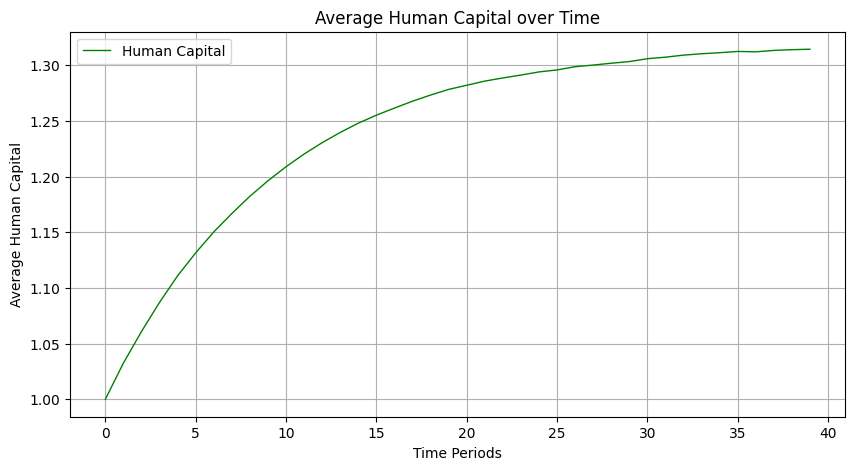

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
num_individuals = 100000  # Increased from 500 for better averaging
num_periods = 40

# Simulation arrays
human_capital = np.zeros((num_periods, num_individuals))

# Initialize human capital
human_capital[0, :] = 1.0  # Assuming all individuals start with a human capital level of 1

# Simulation logic
for t in range(1, num_periods):
    for i in range(num_individuals):
        h_t = 0.5  # Assuming constant labor supply of 0.5 for simplicity
        xi = np.random.lognormal(-0.5 * sigma_xi**2, sigma_xi)
        human_capital[t, i] = ((1 - delta) * human_capital[t-1, i] + phi1 * h_t**phi2) * xi

# Calculate average human capital across individuals at each period
average_human_capital = np.mean(human_capital, axis=1)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(num_periods), average_human_capital, 'g-', label='Human Capital', linewidth=2)
plt.title('Average Human Capital over Time')
plt.xlabel('Time Periods')
plt.ylabel('Average Human Capital')
plt.grid(True)
plt.legend()
plt.show()


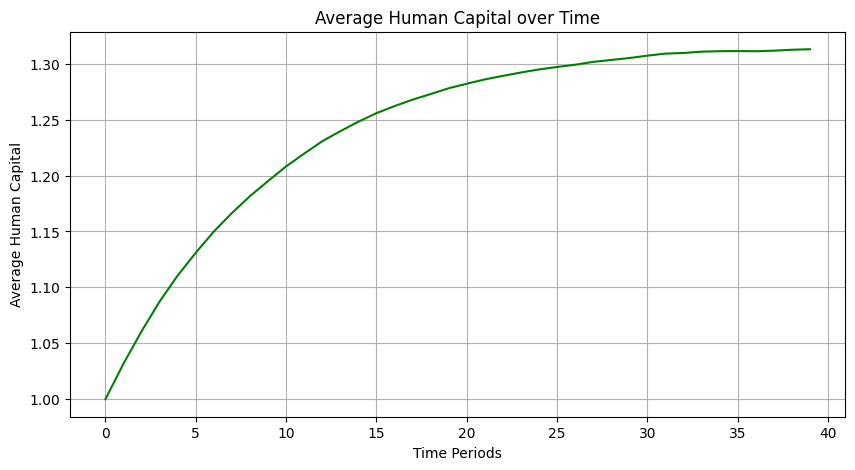

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
num_individuals = 1000  # Number of agents in the simulation
num_periods = 40  # Number of time periods
h_t = 0.5  # Constant labor supply choice for simplicity

# Initialize arrays to store simulation results
human_capital = np.zeros((num_periods, num_individuals))
human_capital[0, :] = 1  # Initial human capital

# Simulation logic
for t in range(1, num_periods):
    for i in range(num_individuals):
        xi = np.random.lognormal(-0.5 * sigma_xi**2, sigma_xi)  # Human capital shock
        human_capital[t, i] = human_capital[t - 1, i] * (1 - delta) + phi1 * h_t**phi2 * xi

# Calculate average human capital across individuals at each period
average_human_capital = np.mean(human_capital, axis=1)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(num_periods), average_human_capital, color='green', label='Human Capital')
plt.title('Average Human Capital over Time')
plt.xlabel('Time Periods')
plt.ylabel('Average Human Capital')
plt.grid(True)
plt.show()
